In [2]:

%matplotlib inline

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random


2025-04-23 06:01:47.888827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745388108.089091      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745388108.147525      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Section 1: Load Dataset

In [8]:
# Section 1: Load Dataset
image_dir = "/kaggle/input/flickr8k/Images"
captions_file = "/kaggle/input/flickr8k/captions.txt"

def load_captions(filepath):
    captions_dict = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(',', 1)
            if len(parts) < 2:
                continue
            image_id, caption = parts
            image_id = image_id.strip()
            if image_id not in captions_dict:
                captions_dict[image_id] = []
            captions_dict[image_id].append("startseq " + caption.strip() + " endseq")
    if not captions_dict:
        raise ValueError("No captions were loaded. Check the captions file format.")
    return captions_dict

captions_dict = load_captions(captions_file)
print(f"Total images with captions: {len(captions_dict)}")

Total images with captions: 8092


# Section 2: Extract Features using InceptionV3 (CNN)

In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

def extract_features(image_path, model):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    feature = model.predict(img, verbose=0)
    return feature

image_features = {}
for img_name in tqdm(os.listdir(image_dir), desc="Extracting image features"):
    img_path = os.path.join(image_dir, img_name)
    image_features[img_name] = extract_features(img_path, base_model).flatten()

with open("image_features.pkl", "wb") as f:
    pickle.dump(image_features, f)


I0000 00:00:1745388288.303432      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting image features:   0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1745388295.222823      94 service.cc:148] XLA service 0x7b1844002d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745388295.223459      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745388296.173443      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745388300.370088      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting image features: 100%|██████████| 8091/8091 [11:37<00:00, 11.61it/s]


In [10]:
import pickle

with open("image_features.pkl", "wb") as f:
    pickle.dump(image_features, f)

print("Features saved to image_features.pkl")


Features saved to image_features.pkl


In [11]:
import pickle

# Load the saved image features
with open("image_features.pkl", "rb") as f:
    image_features = pickle.load(f)

print("Features loaded successfully!")
print(f"Number of images loaded: {len(image_features)}")


Features loaded successfully!
Number of images loaded: 8091


# Section 3: Tokenization of Captions

In [12]:
tokenizer = Tokenizer()
all_captions = [caption for captions in captions_dict.values() for caption in captions]
if not all_captions:
    raise ValueError("No captions found. Ensure the captions file is formatted correctly.")

tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print(f"Total captions loaded: {len(all_captions)}")
print(f"Vocabulary size: {vocab_size}")

Total captions loaded: 40456
Vocabulary size: 8497


# Section 4: Create Sequences for Training

In [13]:
max_length = max(len(caption.split()) for caption in all_captions)
print(f"Max caption length: {max_length}")

input_sequences = []
output_words = []
image_inputs = []
image_filenames = []

for img_id, captions in captions_dict.items():
    if img_id not in image_features:
        continue
    for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
            input_sequences.append(seq[:i])
            output_words.append(seq[i])
            image_inputs.append(image_features[img_id])
            image_filenames.append(img_id)

input_sequences = pad_sequences(input_sequences, maxlen=max_length, padding='post')
output_words = np.array(output_words)
image_inputs = np.vstack(image_inputs)

Max caption length: 40


# Section 5: Split Dataset

In [15]:
X_train_img, X_test_img, X_train_seq, X_test_seq, y_train, y_test, train_names, test_names = train_test_split(
    image_inputs, input_sequences, output_words, image_filenames, test_size=0.2, random_state=42)


# Section 6: Define CNN-LSTM Model

In [16]:
embedding_dim = 256

inputs_img = Input(shape=(2048,))
dense_layer = Dense(embedding_dim, activation='relu')(inputs_img)

inputs_txt = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs_txt)
lstm_layer = LSTM(256)(embedding_layer)

merged = tf.keras.layers.add([dense_layer, lstm_layer])
dense_output = Dense(vocab_size, activation='softmax')(merged)

model = Model(inputs=[inputs_img, inputs_txt], outputs=dense_output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 40, 256)        │      2,175,232 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 40)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8497)           │      2,183,729 │ add[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,408,817 (20.63 MB)

 Trainable params: 5,408,817 (20.63 MB)

 Non-trainable params: 0 (0.00 B)

# Section 7: Train the Model

In [17]:
history = model.fit([X_train_img, X_train_seq], y_train, 
                    validation_data=([X_test_img, X_test_seq], y_test), 
                    batch_size=64, epochs=10, verbose=1)

Epoch 1/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 73s 12ms/step - accuracy: 0.3057 - loss: 4.0189 - val_accuracy: 0.3860 - val_loss: 3.1145
Epoch 2/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step - accuracy: 0.4007 - loss: 2.8583 - val_accuracy: 0.4041 - val_loss: 2.9831
Epoch 3/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step - accuracy: 0.4284 - loss: 2.5550 - val_accuracy: 0.4089 - val_loss: 2.9396
Epoch 4/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step - accuracy: 0.4519 - loss: 2.3423 - val_accuracy: 0.4129 - val_loss: 2.9503
Epoch 5/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step - accuracy: 0.4713 - loss: 2.1893 - val_accuracy: 0.4147 - val_loss: 2.9763
Epoch 6/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step - accuracy: 0.4931 - loss: 2.0505 - val_accuracy: 0.4111 - val_loss: 2.9992
Epoch 7/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.5120 - loss: 1.9423 - val_accuracy: 0.4080 - val_loss: 3.0498
Epoch 8/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.5308 -

In [18]:
# 1. Save the model in the .keras format
model.save("caption_model.keras")
print("Model saved as caption_model.keras")

# 2. Save the training history
import pickle

with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("Training history saved as training_history.pkl")

Model saved as caption_model.keras
Training history saved as training_history.pkl


In [20]:
from tensorflow.keras.models import load_model

model = load_model("caption_model.keras")


# Section 7.1: Plot Accuracy & Loss

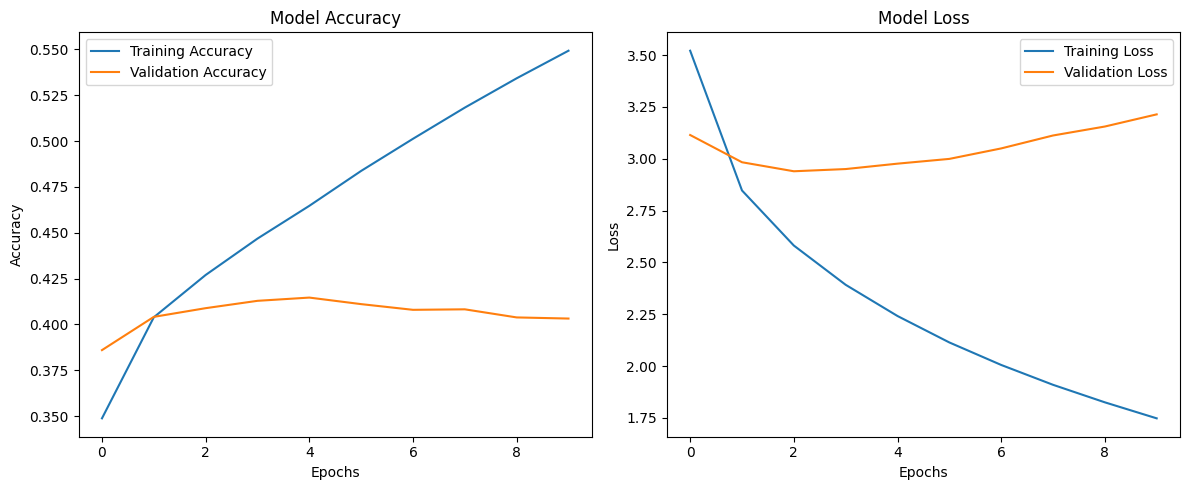

Final Training Accuracy: 0.5492
Final Validation Accuracy: 0.4032


In [21]:

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

plot_training_history(history)


# Section 8: Save Model and Training History

In [22]:
model.save("image_caption_generator.keras")

with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)



# Section 9: Generate Caption

In [25]:
def generate_caption(image_path, model, tokenizer, max_length):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    feature = extract_features(image_path, base_model).flatten()
    caption = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        y_pred = model.predict([feature.reshape(1, -1), sequence], verbose=0)
        word_index = np.argmax(y_pred)
        word = tokenizer.index_word.get(word_index, '')
        if word == "endseq" or word == '':
            break
        caption += ' ' + word
    return caption.replace('startseq', '').replace('endseq', '').strip()

# Section 10: Show Random Test Image & Generated Caption

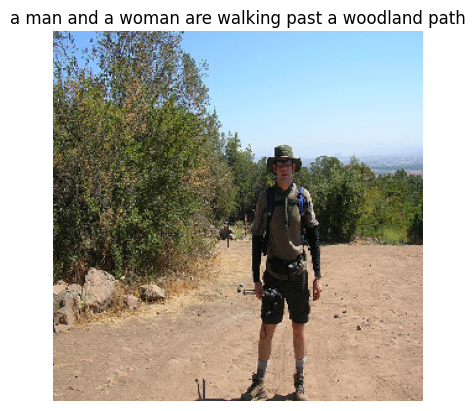

In [29]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Assumptions:
# - image_dir: Path to your image directory
# - generate_caption(): Your function to generate a caption
# - model: Your trained captioning model
# - tokenizer: Tokenizer used during training
# - max_length: Maximum length of caption

# 1. Pick a random image
test_image_name = random.choice(os.listdir(image_dir))
image_path = os.path.join(image_dir, test_image_name)

# 2. Load and display the image
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
plt.imshow(img)
plt.axis("off")

# 3. Generate caption
caption = generate_caption(image_path, model, tokenizer, max_length)

# 4. Show the caption
plt.title(caption)
plt.show()


# Basic hyperparameter Tunning cross validation methode

In [33]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

# Hyperparameters to tune
embedding_dims = [128, 256]
lstm_units_list = [128, 256]
learning_rates = [0.001, 0.0005]

# Best tracking
best_val_acc = 0
best_model = None
best_params = {}

# K-Fold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Assume you already have these loaded properly
# X_train_img, X_train_seq, y_train
# Each of shape: (samples, ...)
# max_length, vocab_size

for embed_dim in embedding_dims:
    for lstm_units in lstm_units_list:
        for lr in learning_rates:
            print(f"\nTesting: Embedding={embed_dim}, LSTM={lstm_units}, LR={lr}")
            fold_accuracies = []

            for fold, (train_index, val_index) in enumerate(kf.split(X_train_img)):
                print(f" Fold {fold + 1}/3")

                # Split the data
                X_train_img_fold = X_train_img[train_index]
                X_val_img_fold = X_train_img[val_index]

                X_train_seq_fold = X_train_seq[train_index]
                X_val_seq_fold = X_train_seq[val_index]

                y_train_fold = y_train[train_index]
                y_val_fold = y_train[val_index]

                # Model definition
                inputs_img = Input(shape=(2048,))
                dense_layer = Dense(embed_dim, activation='relu')(inputs_img)

                inputs_txt = Input(shape=(max_length,))
                embedding_layer = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs_txt)
                lstm_layer = LSTM(lstm_units)(embedding_layer)

                merged = Concatenate()([dense_layer, lstm_layer])
                output = Dense(vocab_size, activation='softmax')(merged)

                model = Model(inputs=[inputs_img, inputs_txt], outputs=output)
                model.compile(loss='sparse_categorical_crossentropy',
                              optimizer=Adam(learning_rate=lr),
                              metrics=['accuracy'])

                # Training
                history = model.fit([X_train_img_fold, X_train_seq_fold], y_train_fold,
                                    validation_data=([X_val_img_fold, X_val_seq_fold], y_val_fold),
                                    epochs=5, batch_size=64, verbose=0)

                val_acc = history.history['val_accuracy'][-1]
                fold_accuracies.append(val_acc)
                print(f"  Fold {fold + 1} Val Accuracy: {val_acc:.4f}")

            avg_val_acc = np.mean(fold_accuracies)
            print(f" Avg Validation Accuracy: {avg_val_acc:.4f}")

            if avg_val_acc > best_val_acc:
                best_val_acc = avg_val_acc
                best_model = model
                best_params = {
                    'embedding_dim': embed_dim,
                    'lstm_units': lstm_units,
                    'learning_rate': lr
                }

print("\nBest Hyperparameters Found:")
print(best_params)



Testing: Embedding=128, LSTM=128, LR=0.001
 Fold 1/3
  Fold 1 Val Accuracy: 0.3881
 Fold 2/3
  Fold 2 Val Accuracy: 0.3916
 Fold 3/3
  Fold 3 Val Accuracy: 0.3914
 Avg Validation Accuracy: 0.3904

Testing: Embedding=128, LSTM=128, LR=0.0005
 Fold 1/3
  Fold 1 Val Accuracy: 0.3976
 Fold 2/3
  Fold 2 Val Accuracy: 0.3981
 Fold 3/3
  Fold 3 Val Accuracy: 0.4020
 Avg Validation Accuracy: 0.3992

Testing: Embedding=128, LSTM=256, LR=0.001
 Fold 1/3
  Fold 1 Val Accuracy: 0.3847
 Fold 2/3
  Fold 2 Val Accuracy: 0.3908
 Fold 3/3
  Fold 3 Val Accuracy: 0.3864
 Avg Validation Accuracy: 0.3873

Testing: Embedding=128, LSTM=256, LR=0.0005
 Fold 1/3
  Fold 1 Val Accuracy: 0.3966
 Fold 2/3
  Fold 2 Val Accuracy: 0.4018
 Fold 3/3
  Fold 3 Val Accuracy: 0.4005
 Avg Validation Accuracy: 0.3996

Testing: Embedding=256, LSTM=128, LR=0.001
 Fold 1/3
  Fold 1 Val Accuracy: 0.3917
 Fold 2/3
  Fold 2 Val Accuracy: 0.3938
 Fold 3/3
  Fold 3 Val Accuracy: 0.3916
 Avg Validation Accuracy: 0.3923

Testing: Emb

In [37]:
# Save the best model to .keras file
best_model.save('best_caption_model.keras')
print("\nBest model saved as 'best_caption_model.keras'")



Best model saved as 'best_caption_model.keras'


In [38]:
# Load the model
loaded_model = tf.keras.models.load_model('best_caption_model.keras')
print("\nModel loaded successfully.")



Model loaded successfully.


#BLEU Score Calculate

In [34]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

# Example: index to word mapping from your tokenizer
index_word = {0: '<pad>', 1: 'a', 2: 'man', 3: 'is', 4: 'walking', 5: 'dog', 6: '.', 7: '<end>'}

def decode_sequence(seq):
    """Convert a sequence of word indices to a sentence"""
    return [index_word.get(idx, '') for idx in seq if idx != 0 and index_word.get(idx) not in ['<pad>', '<end>']]

def compute_bleu(y_true, y_pred):
    """
    Compute average BLEU score (BLEU-1) for predictions.
    :param y_true: array-like of true token IDs, shape (n_samples,)
    :param y_pred: array-like of predicted softmax probs or token IDs, shape (n_samples, vocab_size) or (n_samples,)
    :return: BLEU score (float)
    """
    smooth = SmoothingFunction().method1
    bleu_scores = []

    for true_id, pred in zip(y_true, y_pred):
        reference = [[index_word.get(true_id, '')]]
        
        if isinstance(pred, (list, np.ndarray)) and len(pred) > 1:  # softmax output
            pred_id = np.argmax(pred)
        else:  # already token id
            pred_id = int(pred)

        hypothesis = [index_word.get(pred_id, '')]
        score = sentence_bleu(reference, hypothesis, weights=(1.0,), smoothing_function=smooth)
        bleu_scores.append(score)

    return np.mean(bleu_scores)


In [36]:
y_pred_probs = best_model.predict([X_test_img, X_test_seq])
bleu_score = compute_bleu(y_test, y_pred_probs)
print(f"BLEU Score on test set: {bleu_score:.4f}")


2988/2988 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
BLEU Score on test set: 0.7094


In [44]:
import matplotlib.pyplot as plt
import cv2

def show_predictions(model, tokenizer, max_length, test_imgs, image_dir, num_samples=5):
    for img_name in test_imgs[:num_samples]:
        img_path = os.path.join(image_dir, img_name)
        caption = generate_caption(img_path, model, tokenizer, max_length)

        # Load and show image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Generated Caption:\n{caption}", fontsize=12)
        plt.show()


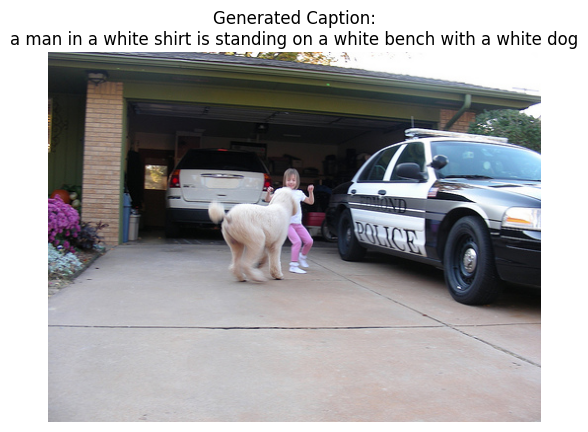

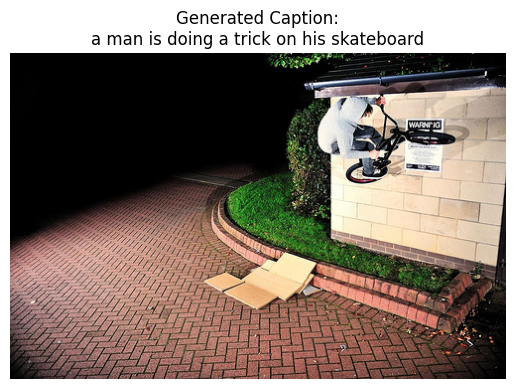

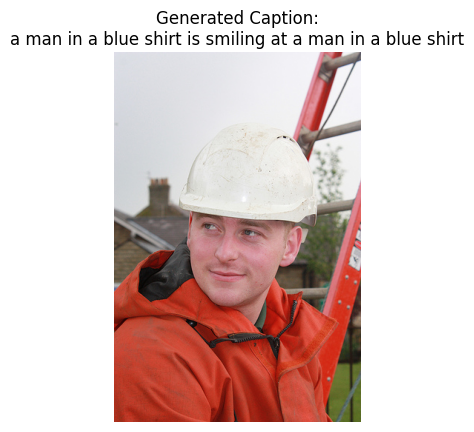

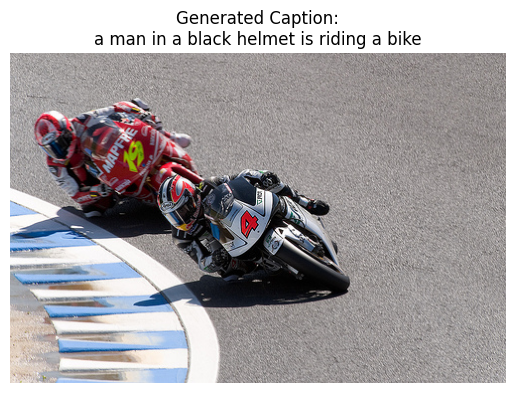

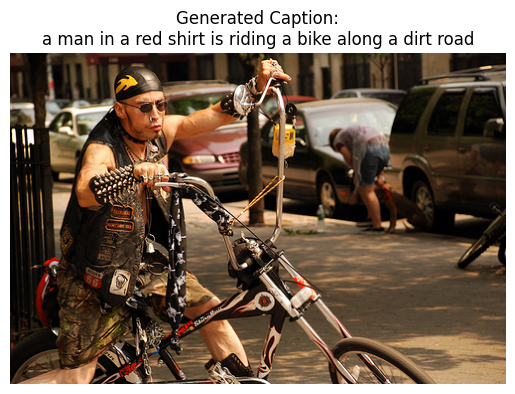

In [45]:
show_predictions(best_model, tokenizer, max_length, test_names, image_dir, num_samples=5)
